# 2D Design Template

#### Import Necessary Libraries

In [ ]:
from typing import TypeAlias
from typing import Optional, Any

Number: TypeAlias = int | float

import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message='.*Dtype inference.*')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
from IPython.display import display

#### Import necessary functions from cohort problem sets

In [ ]:
def normalize_z(array: np.ndarray, columns_means: Optional[np.ndarray]=None,
                columns_stds: Optional[np.ndarray]=None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    assert columns_means is None or columns_means.shape == (1, array.shape[1])
    assert columns_stds is None or columns_stds.shape == (1, array.shape[1])

    if columns_means is None:
        columns_means = array.mean(axis=0).reshape(1, -1)

    if columns_stds is None:
        columns_stds = array.std(axis=0).reshape(1, -1)

    out: np.ndarray = (array - columns_means) / columns_stds

    assert out.shape == array.shape
    assert columns_means.shape == (1, array.shape[1])
    assert columns_stds.shape == (1, array.shape[1])
    return out, columns_means, columns_stds


def get_features_targets(df: pd.DataFrame,
                         feature_names: list[str],
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_feature: pd.DataFrame = df[feature_names] # if feature_names is not list[str] type and just str, then we will get Series and not Dataframe
    df_target: pd.DataFrame = df[target_names]
    return df_feature, df_target


def prepare_feature(np_feature: np.ndarray) -> np.ndarray:
    cols: int = np_feature.shape[1]
    X: np.ndarray = np.concatenate((np.ones((np_feature.shape[0],1)), np_feature), axis = 1 ) # axis = 1 is to concatenate column wise
    return X


def predict_linreg(array_feature: np.ndarray, beta: np.ndarray,
                   means: Optional[np.ndarray]=None,
                   stds: Optional[np.ndarray]=None) -> np.ndarray:
    assert means is None or means.shape == (1, array_feature.shape[1])
    assert stds is None or stds.shape == (1, array_feature.shape[1])
    norm_data, _, _ = normalize_z(array_feature, means, stds)
    X: np.ndarray = prepare_feature(norm_data)
    result = calc_linreg(X, beta)
    assert result.shape == (array_feature.shape[0], 1)
    return result


def calc_linreg(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    result = np.matmul(X, beta)
    assert result.shape == (X.shape[0], 1)
    return result


def compute_cost_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    m = X.shape[0]
    predicted_y = calc_linreg(X, beta)
    error = predicted_y - y
    error_sq = np.matmul(error.T, error)
    J = (1/(2*m)) * error_sq
    assert J.shape == (1, 1)
    return np.squeeze(J)


def gradient_descent_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray,
                            alpha: float, num_iters: int) -> tuple[np.ndarray, np.ndarray]:
    m = X.shape[0]
    J_storage = np.zeros ((num_iters, 1))
    for n in range(num_iters):
        deriv: np.ndarray = np.matmul(X.T, (calc_linreg(X, beta) - y))
        beta = beta - alpha * (1/m) * deriv
        J_storage[n] = compute_cost_linreg(X, y, beta)

    assert beta.shape == (X.shape[1], 1)
    assert J_storage.shape == (num_iters, 1)
    return beta, J_storage


def split_data(df_feature: pd.DataFrame, df_target: pd.DataFrame,
               random_state: Optional[int]=None,
               test_size: float=0.5) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    index = df_feature.index

    if random_state is not None:
        np.random.seed(random_state)

    rows_test_size = int(test_size * len(index))

    # Sample the test index dataset
    test_index = np.random.choice(index, rows_test_size, replace = False)
    train_index = index.drop(test_index)

    # Select data for the output
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index,:]
    df_target_train = df_target.loc[train_index,:]
    df_target_test = df_target.loc[test_index,:]

    return df_feature_train, df_feature_test, df_target_train, df_target_test


# just wrap all the code in CS4 in a function
def build_model_linreg(df_feature_train: pd.DataFrame,
                       df_target_train: pd.DataFrame,
                       beta: Optional[np.ndarray] = None,
                       alpha: float = 0.01,
                       iterations: int = 1500) -> tuple[dict[str, Any], np.ndarray]:
    # check if initial beta values are given
    if beta is None:
        beta = np.zeros((df_feature_train.shape[1]+1, 1)) # add one dimension to the feature_train array because of the b0 coefficient
    assert beta.shape == (df_feature_train.shape[1]+1, 1) # to make sure if beta argument is given, then it conforms to the shape of the feature train

    array_feature_train_z, means, stds = normalize_z(df_feature_train.to_numpy())

    # prepare the X matrix and the target vector as ndarray
    X: np.ndarray = prepare_feature(array_feature_train_z)
    target: np.ndarray = df_target_train.to_numpy()
    beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)
    # store the output in model dictionary
    model = {"beta": beta, "means":means, "stds": stds}

    # assert the shapes
    assert model["beta"].shape == (df_feature_train.shape[1] + 1, 1) # make sure that beta vector is d by 1
    assert model["means"].shape == (1, df_feature_train.shape[1]) # make sure that the means vector is also d-1 by 1 (1 per feature)
    assert model["stds"].shape == (1, df_feature_train.shape[1])  # make sure that the stds vector is also d-1 by 1 (1 per feature)
    assert J_storage.shape == (iterations, 1) # make sure we have recorded #iterations of error
    return model, J_storage


def r2_score(y: np.ndarray, ypred: np.ndarray) -> float:
    res = np.sum((y - ypred)**2)
    tot = np.sum((y - y.mean())**2)
    return 1 - res / tot


def mean_squared_error(target: np.ndarray, pred: np.ndarray) -> float:
    return np.sum((target - pred)**2)/target.shape[0]

#### Loading Raw Data

In [ ]:
df1 = pd.read_csv('./LCL_2013.csv')

df1

In [ ]:
df2 = pd.read_csv('./all_weather_data.csv')

df2

### Clean & Analyze your data
Use python code to:
- Clean your data
- Calculate Descriptive Statistics and other statistical analysis
- Visualization with meaningful analysis description

#### `LCL.csv` (Average Household Power Usage)

1. Compute average energy average usage across all households.
2. Convert energy usage data into daily scale.

In [ ]:
# Create a proper copy of the dataframe and ensure clean dtypes
df1_pp = df1.iloc[:-1].copy()

# Drop columns where there are households with readings that are NaN
df1_pp = df1_pp.dropna(axis='columns', how='any')

# Convert DateTime column into datetime format with explicit parameters
df1_pp.loc[:, 'DateTime'] = pd.to_datetime(df1_pp['DateTime'], format='mixed', errors='coerce')

# Set index and ensure it's properly typed
df1_pp = df1_pp.set_index('DateTime')

# Resample by day ('D') and sum each column (i.e. each household)
df_daily = df1_pp.resample('D').sum()

# Reset index so 'DateTime' becomes a column again
df_daily = df_daily.reset_index()

# Exclude non-household columns (e.g., 'DateTime')
mac_columns = [col for col in df_daily.columns if col.startswith('MAC')]

# Compute row-wise average across all MAC* columns
df_daily['Household Average'] = df_daily[mac_columns].mean(axis=1, skipna=True)

# Create final dataframe with just DateTime and average
df_daily_average = df_daily[['DateTime', 'Household Average']].copy()

In [ ]:
display(df_daily_average), display(df_daily_average.describe())

#### `all_weather_data.csv` (Weather stats in London)

1. Filter data to include only records from the year 2013.
2. Select London data only.

In [ ]:
df2_pp = df2.copy()

# Filter for London AND year 2013 in one operation
df2_london_2013 = df2_pp[
    (df2_pp['location'] == 'London') &
    (pd.to_datetime(df2_pp['date']).dt.year == 2013)
].copy()

df2_london_2013['average_temp °c'] = (df2_london_2013['min_temp °c'] + df2_london_2013['max_temp °c']) / 2

# Ensure date column is datetime format
df2_london_2013['date'] = pd.to_datetime(df2_london_2013['date'])

column_order = [
    'location', 'date', 'min_temp °c', 'average_temp °c', 'max_temp °c',
    'rain mm', 'humidity %', 'cloud_cover %', 'wind_speed km/h',
    'wind_direction', 'wind_direction_numerical'
]

# Reorder the dataframe
df2_london_2013 = df2_london_2013[column_order]

In [ ]:
display(df2_london_2013), display(df2_london_2013.describe())

#### Seasonal Classification

1. Correlate both datasets base on date.
2. Segment dataset by season for further analysis.

In [ ]:
# Add season classification
def get_season(date):
    """
    Classify date into seasons based on meteorological seasons:
    - Winter: December, January, February
    - Spring: March, April, May
    - Summer: June, July, August
    - Fall/Autumn: September, October, November
    """
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Fall'

In [ ]:
# Apply season classification using .loc to avoid warning
df_daily_average.loc[:, 'Season'] = df_daily_average['DateTime'].apply(get_season)

# Split data into seasonal dataframes
winter_data = df_daily_average[df_daily_average['Season'] == 'Winter'].copy()

In [ ]:
# Add season column
df2_london_2013['season'] = df2_london_2013['date'].apply(get_season)

# Split data into seasonal dataframes
winter_weather = df2_london_2013[df2_london_2013['season'] == 'Winter'].copy()

In [ ]:
winter_data = pd.merge(
    winter_data,           # energy data with 'DateTime' and 'Household Average'
    winter_weather,        # weather data with 'date' and 'average_temp'
    left_on='DateTime',    # date column in energy data
    right_on='date',       # date column in weather data
    how='inner'            # only dates that exist in both datasets
)

In [ ]:
display(winter_data), display(winter_data.describe())

In [ ]:
# visualization with analysis

### Features and Target Preparation

Prepare features and target for model training.

In [ ]:
# put Python code to prepare your features and target
FEATURE_NAMES = ["average_temp °c", "humidity %", "wind_speed km/h"]
TARGET_NAMES = ["Household Average"]

df_feature_winter, df_target_winter = get_features_targets(winter_data, FEATURE_NAMES, TARGET_NAMES)

#### Analysis using the raw data

In [349]:
# Split the raw features and target using your split_data function
df_feature_train_winter_raw, df_feature_test_winter_raw, df_target_train_winter_raw, df_target_test_winter_raw = split_data(df_feature_winter, df_target_winter, random_state=100, test_size=0.3)

# Prepare features (add bias column)
X_train = prepare_feature(df_feature_train_winter_raw.to_numpy())
y_train = df_target_train_winter_raw.to_numpy().reshape(-1, 1)

X_test = prepare_feature(df_feature_test_winter_raw.to_numpy())
y_test = df_target_test_winter_raw.to_numpy().reshape(-1, 1)

# Compute beta using normal equation
# beta = (X^T X)^(-1) X^T y
# It calculates the optimal coefficients β that minimize the sum of squared errors between your predicted values and actual target values in a linear regression model.
beta = np.matmul(np.linalg.pinv(np.matmul(X_train.T, X_train)), np.matmul(X_train.T, y_train))

# Predict
pred_test = calc_linreg(X_test, beta)

r2_winter_raw = r2_score(y_test, pred_test)
mse_winter_raw = mean_squared_error(y_test, pred_test)

print('r2_winter_raw:', r2_winter_raw)
print('mse_winter_raw:', mse_winter_raw)

r2_winter_raw: 0.5290198709033408
mse_winter_raw: 0.3272400069980804


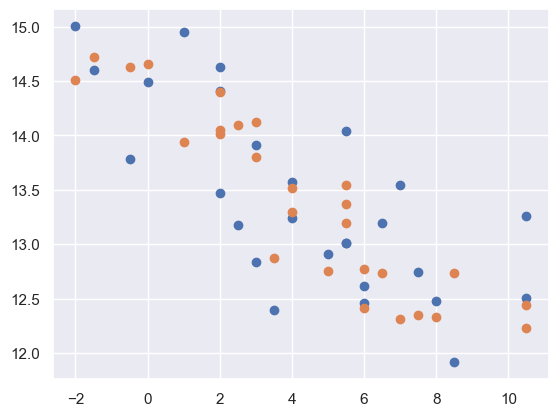

In [350]:
plt.scatter(df_feature_test_winter_raw["average_temp °c"], y_test)
plt.scatter(df_feature_test_winter_raw["average_temp °c"], pred_test)

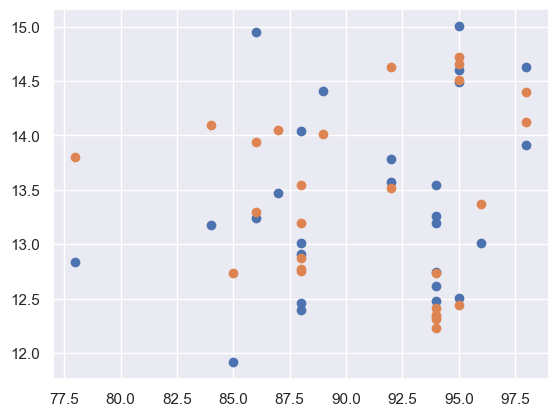

In [351]:
plt.scatter(df_feature_test_winter_raw["humidity %"], y_test)
plt.scatter(df_feature_test_winter_raw["humidity %"], pred_test)

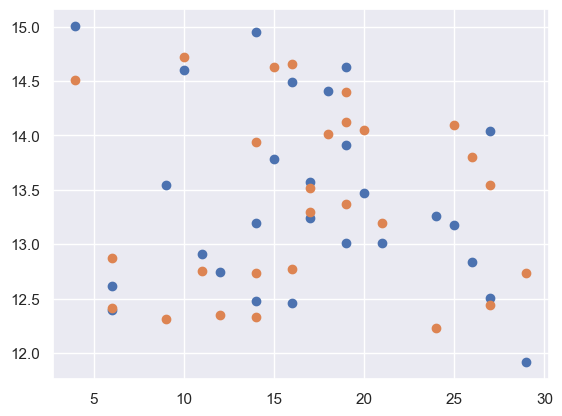

In [352]:
plt.scatter(df_feature_test_winter_raw["wind_speed km/h"], y_test)
plt.scatter(df_feature_test_winter_raw["wind_speed km/h"], pred_test)

### Improving the Model

- Improve the models by performing any data processing techniques or hyperparameter tuning.
- You can repeat the steps above to show the improvement as compared to the previous performance

Note:
- You should not change or add dataset at this step
- You are allowed to use library such as sklearn for data processing (NOT for building model)
- Make sure to have the same test dataset so the results are comparable with the previous model 
- If you perform hyperparameter tuning, it will require you to split your training data further into train and validation dataset

In [353]:
array_feature_winter, _, _ = normalize_z(df_feature_winter.to_numpy())

In [354]:
df_features_winter: pd.DataFrame = pd.DataFrame(array_feature_winter, columns=df_feature_winter.columns)
display(df_features_winter.describe()), display(df_target_winter.describe())

,average_temp °c,humidity %,wind_speed km/h
count,9.000000e+01,9.000000e+01,9.000000e+01
mean,8.881784e-17,-1.049778e-15,2.023073e-16
std,1.005602e+00,1.005602e+00,1.005602e+00
min,-2.171715e+00,-3.304895e+00,-1.917526e+00
25%,-6.411407e-01,-4.938798e-01,-6.417526e-01
50%,1.241466e-01,1.210298e-01,-6.185567e-02
75%,7.363765e-01,7.359394e-01,5.180412e-01
max,1.960836e+00,1.438693e+00,2.567010e+00


,Household Average
count,90.000000
mean,13.381884
std,0.931525
min,11.917518
25%,12.622610
50%,13.195831
75%,14.038392
max,16.390672


(None, None)

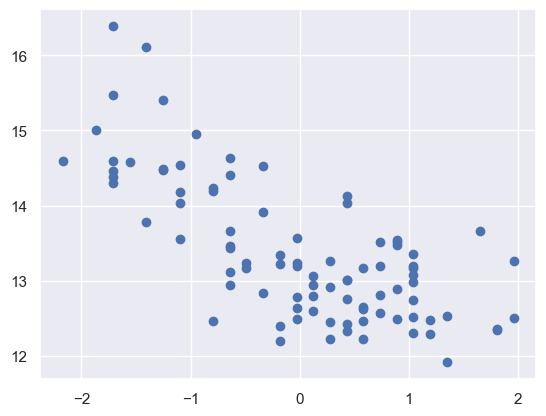

In [355]:
sns.set()
plt.scatter(df_features_winter["average_temp °c"], df_target_winter)

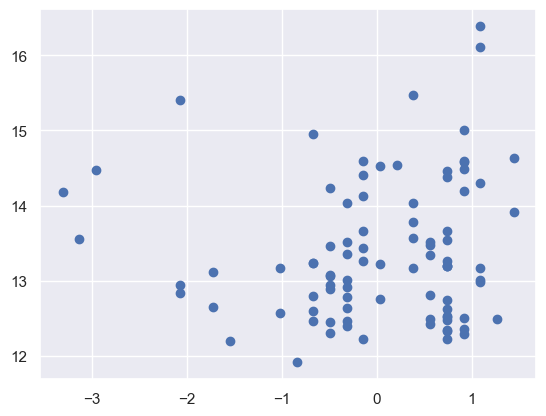

In [356]:
sns.set()
plt.scatter(df_features_winter["humidity %"], df_target_winter)

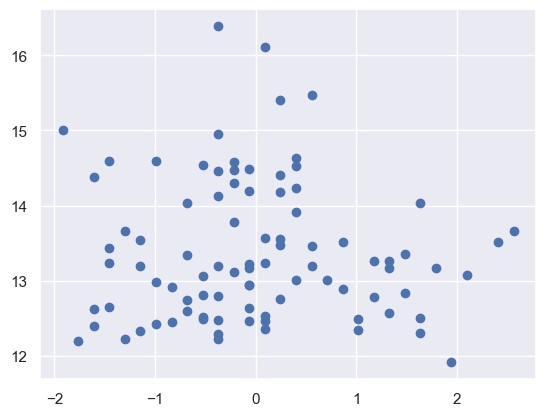

In [357]:
sns.set()
plt.scatter(df_features_winter["wind_speed km/h"], df_target_winter)

### Building Model

Use python code to build your model. Give explanation on this process.

#### Cost Function

In [358]:
# put Python code to build your model
X_winter: np.ndarray = prepare_feature(df_features_winter.to_numpy())
target_winter: np.ndarray = df_target_winter.to_numpy()
beta_winter: np.ndarray = np.zeros((4,1))
J_winter: np.ndarray = compute_cost_linreg(X_winter, target_winter, beta_winter)
print(J_winter)

89.96645534922662


#### Gradient descent

In [359]:
iterations: int = 1500
alpha: float = 0.01

beta_winter: np.ndarray = np.zeros((4,1))
beta_spring: np.ndarray = np.zeros((4,1))
beta_summer: np.ndarray = np.zeros((4,1))
beta_fall: np.ndarray = np.zeros((4,1))

beta_winter, J_storage_winter = gradient_descent_linreg(X_winter, target_winter, beta_winter, alpha, iterations)
print('beta_winter: \n', beta_winter)
print('J_storage_winter: \n', J_storage_winter)

beta_winter: 
 [[13.38187998]
 [-0.82521816]
 [ 0.2493265 ]
 [ 0.29571266]]
J_storage_winter: 
 [[88.18017579]
 [86.42944463]
 [84.71355411]
 ...
 [ 0.15237542]
 [ 0.15237542]
 [ 0.15237542]]


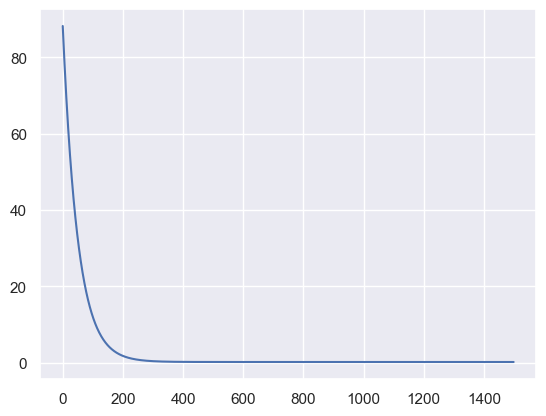

In [360]:
plt.plot(J_storage_winter)

#### Predict Linear Regression

In [361]:
# Call predict()
pred_winter: np.ndarray = predict_linreg(df_features_winter.to_numpy(), beta_winter)

# Change target to numpy array
target_winter: np.ndarray = df_target_winter.to_numpy()

print("Winter")
print(pred_winter[0], pred_winter[1], pred_winter[2])
print(target_winter[0], target_winter[1], target_winter[2])
print(pred_winter.mean(), pred_winter.std())

Winter
[13.10826042] [13.15331982] [12.14479842]
[12.75519523] [13.17318388] [12.35783882]
13.381879984666146 0.7437006812855075


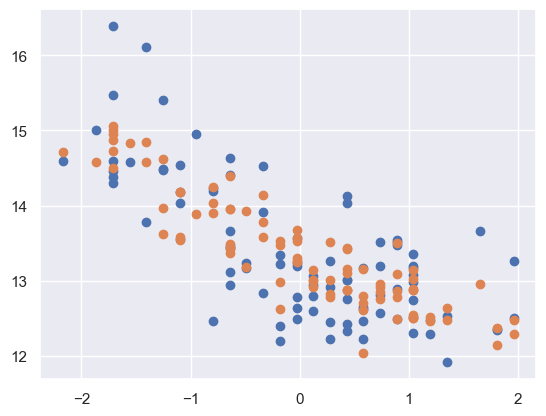

In [362]:
plt.scatter(df_features_winter["average_temp °c"],target_winter)
plt.scatter(df_features_winter["average_temp °c"],pred_winter)

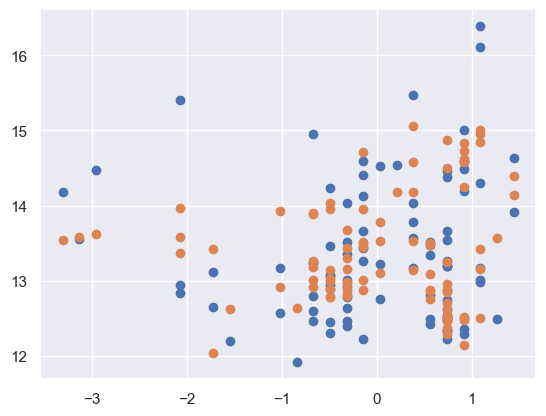

In [363]:
plt.scatter(df_features_winter["humidity %"],target_winter)
plt.scatter(df_features_winter["humidity %"],pred_winter)

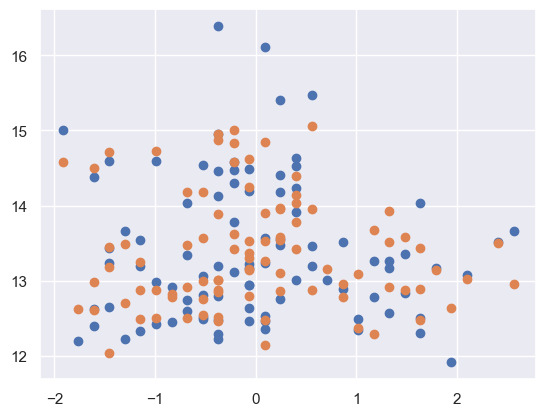

In [364]:
plt.scatter(df_features_winter["wind_speed km/h"],target_winter)
plt.scatter(df_features_winter["wind_speed km/h"],pred_winter)

### Evaluating the Model

- Describe the metrics of your choice
- Evaluate your model performance

#### Splitting Data

In [365]:
# Split the data set into training and test
df_features_train_winter, df_features_test_winter, df_target_train_winter, df_target_test_winter = split_data(df_features_winter, df_target_winter, random_state=100, test_size=0.3)
# call build_model_linreg() function
model_winter, J_storage_winter = build_model_linreg(df_features_train_winter, df_target_train_winter)
# call the predict_linreg() method
pred_winter: np.ndarray = predict_linreg(df_features_test_winter.to_numpy(), model_winter['beta'], model_winter['means'], model_winter['stds'])

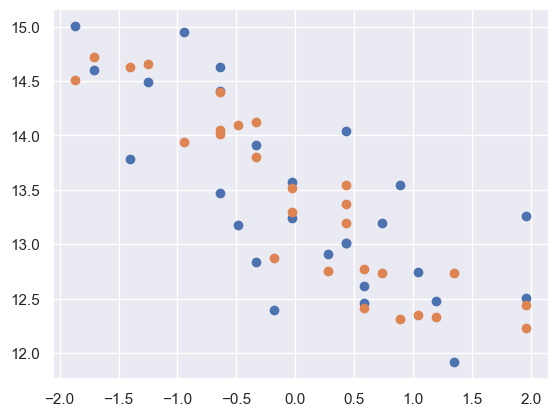

In [366]:
plt.scatter(df_features_test_winter["average_temp °c"], df_target_test_winter)
plt.scatter(df_features_test_winter["average_temp °c"], pred_winter)

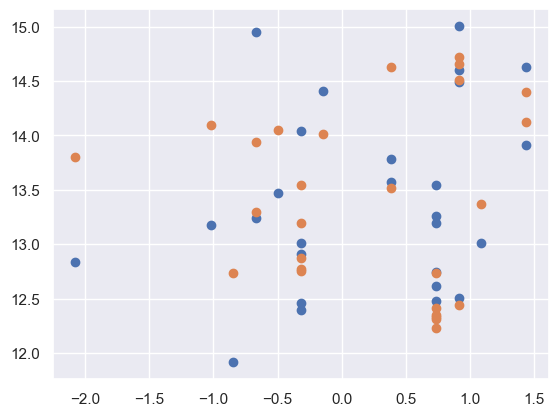

In [367]:
plt.scatter(df_features_test_winter["humidity %"], df_target_test_winter)
plt.scatter(df_features_test_winter["humidity %"], pred_winter)

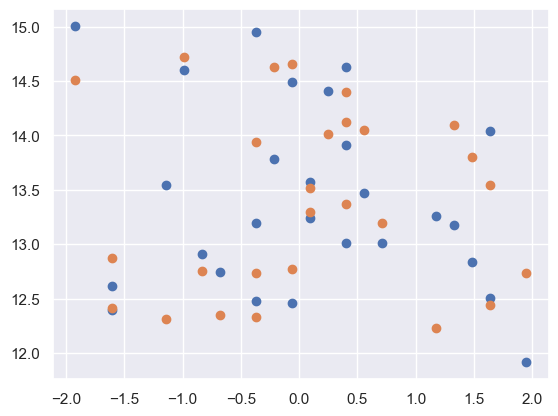

In [368]:
plt.scatter(df_features_test_winter["wind_speed km/h"], df_target_test_winter)
plt.scatter(df_features_test_winter["wind_speed km/h"], pred_winter)

#### R<sup>2</sup> Score (Coefficient of Determination)

In [369]:
target_winter: np.ndarray = df_target_test_winter.to_numpy()
r2_winter: float = r2_score(target_winter, pred_winter)

print('r2_winter:', r2_winter)

r2_winter: 0.5291475088654969


#### Mean Square Error

In [370]:
mse_winter: float = mean_squared_error(target_winter, pred_winter)

print('mse_winter:', mse_winter)

mse_winter: 0.3271513233253546
